# Tabular Playground Series - Feb 2022

Bacterial genetics is the study of the structure and distribution of hereditary information in bacteria. Although many species are often considered harmful, some can actually be helpful. In fact, we would not exist without them. The study of bacteria has been used across many industries to provide a variety of benefits from creating new antibiotics and medications to developing genetic enzymes that can break down organic compounds, like plastic.

Bacteroides_fragilis: nomal microbiota in human colon (🤢 gastroenteritis:opportunistic infection)

Streptococcus_pyogenes : 🤒 pneumonia

Streptococcus_pneumoniae : 🤒 pneumococcus
Campylobacter_jejuni : 🤢 gastroenteritis
Salmonella_enterica : 🤢 gastroenteritis
Escherichia_coli(E.coli): 🤢(EPEC,ETEC),recombinant DNA : K-12
Enterococcus_hirae : 🩸sepsis, VRE
Escherichia_fergusonii : 🤢 diarrhea
Staphylococcus_aureus : 🤢 gastroenteritis, fester,MRSA
Klebsiella_pneumoniae : 🤒 pneumonia 🩸sepsis (Copportunistic infection)

# Data overview

Each row of data contains the spectrum of histograms generated by repeated measurements of the sample. The output of all 286 histogram possibilities ( A0T0G0C10 to A10T0G0C0 ) then has a bias spectrum (of totally random ATGC ) subtracted from the results.

The training set consists of 200,000 bacteria across 10 different species including Bacteroides fragilis, Campylobacter jejuni, Enterococcus hirae, Escherichia coli, Escherichia fergusonii, Klebsiella pneumoniae, Salmonella enterica, Staphylococcus aureus, Streptococcus pneumoniae, Streptococcus pyogenes. The data set also contains several duplicated rows. These will be removed before beginning the analysis.

In [31]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

train = pd.read_csv("/home/mikhail/data/train.csv")
test = pd.read_csv("/home/mikhail/data/test.csv")
sub = pd.read_csv('/home/mikhail/data/sample_submission.csv')

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()
print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

Train Shape: (200000, 288)
Missing Data: 0
Duplicates: 0

Test Shape: (100000, 287)
Missing Data: 0
Duplicates: 0

Dropping Duplicates
New Train Shape: (200000, 288)


In [2]:
# train.head(3)

In [3]:
# test.head(3)

## Summary Statistics Grouped by Species

In [4]:
train_d.groupby('target').describe()

row_id                                     \
                            count           mean           std   min   
target                                                                 
Bacteroides_fragilis      20139.0   99673.791350  57686.175289  20.0   
Campylobacter_jejuni      20063.0   99768.551114  57418.400446   7.0   
Enterococcus_hirae        19947.0  100175.327618  57791.628581   4.0   
Escherichia_coli          19958.0  100236.113138  57834.548191   5.0   
Escherichia_fergusonii    19937.0  100426.582134  57983.764721  12.0   
Klebsiella_pneumoniae     19847.0   99858.289767  57897.004884  21.0   
Salmonella_enterica       20030.0   99704.899401  57344.836089   1.0   
Staphylococcus_aureus     19929.0   99487.238948  57715.496370  11.0   
Streptococcus_pneumoniae  20074.0  100006.762379  57727.248258   8.0   
Streptococcus_pyogenes    20076.0  100657.758318  57954.849574   0.0   

                                                                  A0T0G0C10  \
                               25%       50%        75%       max     count   
target                                                                        
Bacteroides_fragilis      49648.50   99546.0  149223.50  199991.0   20139.0   
Campylobacter_jejuni      50099.00  100250.0  149196.50  199965.0   20063.0   
Enterococcus_hirae        50206.50  100025.0  149972.00  199985.0   19947.0   
Escherichia_coli          50328.00  100270.0  150273.50  199993.0   19958.0   
Escherichia_fergusonii    50016.00  100923.0  151263.00  199992.0   19937.0   
Klebsiella_pneumoniae     48864.50  100177.0  150358.50  199999.0   19847.0   
Salmonella_enterica       50729.25   99174.0  149071.75  199995.0   20030.0   
Staphylococcus_aureus     49613.00   99684.0  149216.00  199998.0   19929.0   
Streptococcus_pneumoniae  50017.75   99600.5  150336.00  199997.0   20074.0   
Streptococcus_pyogenes    50453.25  100557.5  150957.00  199996.0   20076.0   

                                        ...  A9T1G0C0          A10T0G0C0  \
                                  mean  ...       75%      max     count   
target                                  ...                                
Bacteroides_fragilis     -1.343019e-09  ...  0.000072  0.00999   20139.0   
Campylobacter_jejuni      1.077368e-05  ...  0.000411  0.01999   20063.0   
Enterococcus_hirae       -8.997314e-07  ...  0.000280  0.00999   19947.0   
Escherichia_coli         -4.004626e-07  ...  0.000030  0.00999   19958.0   
Escherichia_fergusonii   -1.439236e-07  ...  0.000036  0.00999   19937.0   
Klebsiella_pneumoniae    -1.151681e-08  ...  0.000026  0.00999   19847.0   
Salmonella_enterica      -2.352020e-07  ...  0.000037  0.00999   20030.0   
Staphylococcus_aureus    -8.974246e-07  ...  0.000130  0.00999   19929.0   
Streptococcus_pneumoniae -8.983291e-07  ...  0.000080  0.00999   20074.0   
Streptococcus_pyogenes   -8.980856e-07  ...  0.000098  0.00999   20076.0   

                                                                    \
                                  mean           std           min   
target                                                               
Bacteroides_fragilis     -4.038456e-07  1.591216e-06 -9.536743e-07   
Campylobacter_jejuni     -4.816612e-07  1.346655e-06 -9.536743e-07   
Enterococcus_hirae        4.787740e-06  5.300511e-05 -9.536743e-07   
Escherichia_coli         -8.179894e-07  3.424623e-07 -9.536743e-07   
Escherichia_fergusonii   -8.160408e-07  3.445236e-07 -9.536743e-07   
Klebsiella_pneumoniae    -7.570199e-07  6.382867e-07 -9.536743e-07   
Salmonella_enterica      -5.488316e-07  1.243529e-06 -9.536743e-07   
Staphylococcus_aureus    -8.135268e-07  3.471487e-07 -9.536743e-07   
Streptococcus_pneumoniae  2.580649e-06  3.680675e-05 -9.536743e-07   
Streptococcus_pyogenes   -5.167845e-07  1.380726e-06 -9.536743e-07   

                                                                    \
                                   25%           50%           75%   
target                

# Exploratory Data Analysis (EDA)

In [5]:
def check(df):
    col_list = df.columns.values
    rows = []
    for col in col_list:
        tmp = (col,
              train_d[col].dtype,
              train_d[col].isnull().sum(),
              train_d[col].count(),
              train_d[col].nunique(),
              train_d[col].unique())
        rows.append(tmp)
    df = pd.DataFrame(rows) 
    df.columns = ['feature','dtype','nan','count','nunique','unique']
    return df

check(train)

feature    dtype  nan   count  nunique  \
0       row_id    int64    0  200000   200000   
1    A0T0G0C10  float64    0  200000       18   
2     A0T0G1C9  float64    0  200000       23   
3     A0T0G2C8  float64    0  200000      139   
4     A0T0G3C7  float64    0  200000      683   
..         ...      ...  ...     ...      ...   
283   A9T0G0C1  float64    0  200000      354   
284   A9T0G1C0  float64    0  200000      509   
285   A9T1G0C0  float64    0  200000      515   
286  A10T0G0C0  float64    0  200000       22   
287     target   object    0  200000       10   

                                                unique  
0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1    [-9.5367431640625e-07, 4.632568359374996e-08, ...  
2    [-9.5367431640625e-06, -1.5367431640625004e-06...  
3    [-4.291534423828125e-05, 7.084655761718752e-06...  
4    [-0.0001144409179687, 0.0008855590820312, 0.00...  
..                                                 ...  
283  [-9.5367431640625e-06, 1.0463256835937502e-05,...  
284  [-9.5367431640625e-06, 8.4632568359375e-06, 1....  
285  [-9.5367431640625e-06, 1.94632568359375e-05, 4...  
286  [-9.5367431640625e-07, 1.04632568359375e-06, 6...  
287  [Streptococcus_pyogenes, Salmonella_enterica, ...  

[288 rows x 6 columns]

In [6]:
train_d['target'].value_counts()

Bacteroides_fragilis        20139
Streptococcus_pyogenes      20076
Streptococcus_pneumoniae    20074
Campylobacter_jejuni        20063
Salmonella_enterica         20030
Escherichia_coli            19958
Enterococcus_hirae          19947
Escherichia_fergusonii      19937
Staphylococcus_aureus       19929
Klebsiella_pneumoniae       19847
Name: target, dtype: int64

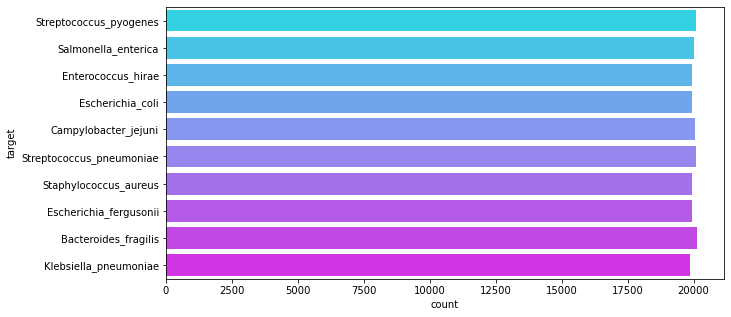

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(y=train_d['target'], palette='cool', orient='h')
plt.show()

or

In [8]:
init_notebook_mode(connected=True)
pal = sns.color_palette("mako_r", 12).as_hex()[:10]
bact=train_d.target.value_counts(normalize=True).reset_index()
bact.target=bact.target.mul(100).sort_values(ascending=False)
bact['index']=bact['index'].str.replace('_', ' ') 

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = px.bar(bact, x='index', y='target', text='target', color='index', 
             color_discrete_sequence=pal, opacity=0.8)
fig.update_traces(texttemplate='%{text:,.2f}%', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(template=temp, title_text='Distribution of Bacteria Species', 
                  xaxis=dict(title='', tickangle=25, showline=True), 
                  height=450, width=700, showlegend=False)
fig.show()

The class distribution in our target variable is evenly balanced with 10% of each species represented in the data.

## Correlations Between Genes

In [9]:
cor=train_d.corr()    
cor.style.background_gradient(cmap='viridis')

## Most Correlated Gene Pairs

In [10]:
c = cor.abs().unstack().drop_duplicates().reset_index()
c = c.rename(columns={'level_0': 'Gene 1', 'level_1': 'Gene 2', 0: 'Correlation'})
c = c.query('.75 <= Correlation < 1').sort_values(by = 'Correlation', ascending = False).reset_index(drop=True)
c.style.background_gradient(cmap='flare_r')

## Most Correlated Genes in Each Species

In [11]:
for i in train_d.target.unique():
    cor_df=train_d[train_d.target==i]
    cor=cor_df.corr()  
    c = cor.abs().unstack().drop_duplicates().reset_index()
    c = c.rename(columns={'level_0': 'Gene 1', 'level_1': 'Gene 2', 0: 'Correlation'})
    c = c.query('Correlation < 1').sort_values(by = 'Correlation', ascending = False).reset_index(drop=True)
    display(c.iloc[:1,:].style.background_gradient(cmap='flare').set_caption('Most correlated genes in {}'.format(i.replace('_', ' '))))

# Feature Engineering (FE)

## Label encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

train_d['target_cols'] = label.fit_transform(train_d['target'])
train_d.head()

row_id     A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  \
0       0 -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
1       1 -9.536743e-07 -0.000010 -0.000043  0.000886 -0.000200  0.000760   
2       2 -9.536743e-07 -0.000002  0.000007  0.000129  0.000268  0.000270   
3       3  4.632568e-08 -0.000006  0.000012  0.000245  0.000492  0.000522   
4       4 -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   

   A0T0G6C4  A0T0G7C3  A0T0G8C2  ...  A8T0G2C0  A8T1G0C1  A8T1G1C0  A8T2G0C0  \
0 -0.000200 -0.000114 -0.000043  ... -0.000043 -0.000086 -0.000086 -0.000043   
1 -0.000200 -0.000114 -0.000043  ... -0.000043  0.000914  0.000914 -0.000043   
2  0.000243  0.000125  0.000001  ...  0.000048  0.000081  0.000106  0.000072   
3  0.000396  0.000197 -0.000003  ...  0.000100  0.000180  0.000202  0.000153   
4 -0.000200 -0.000114 -0.000043  ... -0.000043 -0.000086 -0.000086 -0.000043   

   A9T0G0C1  A9T0G1C0  A9T1G0C0     A10T0G0C0                  target  \
0 -0.000010 -0.000010 -0.000010 -9.536743e-07  Streptococcus_pyogenes   
1 -0.000010 -0.000010 -0.000010 -9.536743e-07     Salmonella_enterica   
2  0.000010  0.000008  0.000019  1.046326e-06     Salmonella_enterica   
3  0.000021  0.000015  0.000046 -9.536743e-07     Salmonella_enterica   
4 -0.000010 -0.000010 -0.000010 -9.536743e-07      Enterococcus_hirae   

   target_cols  
0            9  
1            6  
2            6  
3            6  
4            2  

[5 rows x 289 columns]

Drop

In [13]:
train.drop_duplicates(keep='first', inplace=True)
X = train_d.drop(columns=['target', 'target_cols'], axis=1)
y = train_d['target_cols']
X.drop('row_id', inplace=True, axis=1)
test.drop('row_id', inplace=True, axis=1)
X.head(2)

A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  A0T0G6C4  \
0 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
1 -9.536743e-07  -0.00001 -0.000043  0.000886   -0.0002   0.00076   -0.0002   

   A0T0G7C3  A0T0G8C2  A0T0G9C1  ...  A8T0G0C2  A8T0G1C1  A8T0G2C0  A8T1G0C1  \
0 -0.000114 -0.000043  -0.00001  ... -0.000043 -0.000086 -0.000043 -0.000086   
1 -0.000114 -0.000043  -0.00001  ... -0.000043 -0.000086 -0.000043  0.000914   

   A8T1G1C0  A8T2G0C0  A9T0G0C1  A9T0G1C0  A9T1G0C0     A10T0G0C0  
0 -0.000086 -0.000043  -0.00001  -0.00001  -0.00001 -9.536743e-07  
1  0.000914 -0.000043  -0.00001  -0.00001  -0.00001 -9.536743e-07  

[2 rows x 286 columns]

In [14]:
y.head(2)

0    9
1    6
Name: target_cols, dtype: int64

## DNA rules

In [15]:
target = 'target'
# columns
feature = [col for col in train.columns if col not in ['row_id', target]]

* It is known that bacterial DNA always starts with 'ATG' and end with 'TAA','TAG','TGA'.
* and also length is a multiple of 3.
* How many features which follow the rules? Let's find out

In [16]:
# memory usage (Type of data are object and float64)
for col in feature:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")

In [17]:
n = len(feature)
f = []
r = []
for i in range(n):
    a = feature[i]
    if a[1] == a[3] and a[5] == a[7]:
        f.append(a)
        r.append(i)
        
print(f,r, len(r))

['A0T0G5C5', 'A1T1G4C4', 'A2T2G3C3', 'A3T3G2C2', 'A4T4G1C1', 'A5T5G0C0'] [5, 80, 141, 189, 225, 250] 6


* It is known that bacterial DNA always starts with 'ATG' and end with 'TAA','TAG','TGA'.
* and also length is a multiple of 3.
* How many features which follow the rules? Let's find out

In [18]:
n = len(feature)
fb = []
r = []
for i in range(n):
    a = feature[i]
    if a[0] == 'A' and a[1] == '1' and a[2] == 'T' and a[3] == '1'  and a[4] == 'G' and int(a[5]) > 0:
        fb.append(a)
        r.append(i)
        
print(fb,r, len(r))

['A1T1G1C7', 'A1T1G2C6', 'A1T1G3C5', 'A1T1G4C4', 'A1T1G5C3', 'A1T1G6C2', 'A1T1G7C1', 'A1T1G8C0'] [77, 78, 79, 80, 81, 82, 83, 84] 8


In [19]:
f = f + fb
print(f)
print(len(f))

['A0T0G5C5', 'A1T1G4C4', 'A2T2G3C3', 'A3T3G2C2', 'A4T4G1C1', 'A5T5G0C0', 'A1T1G1C7', 'A1T1G2C6', 'A1T1G3C5', 'A1T1G4C4', 'A1T1G5C3', 'A1T1G6C2', 'A1T1G7C1', 'A1T1G8C0']
14


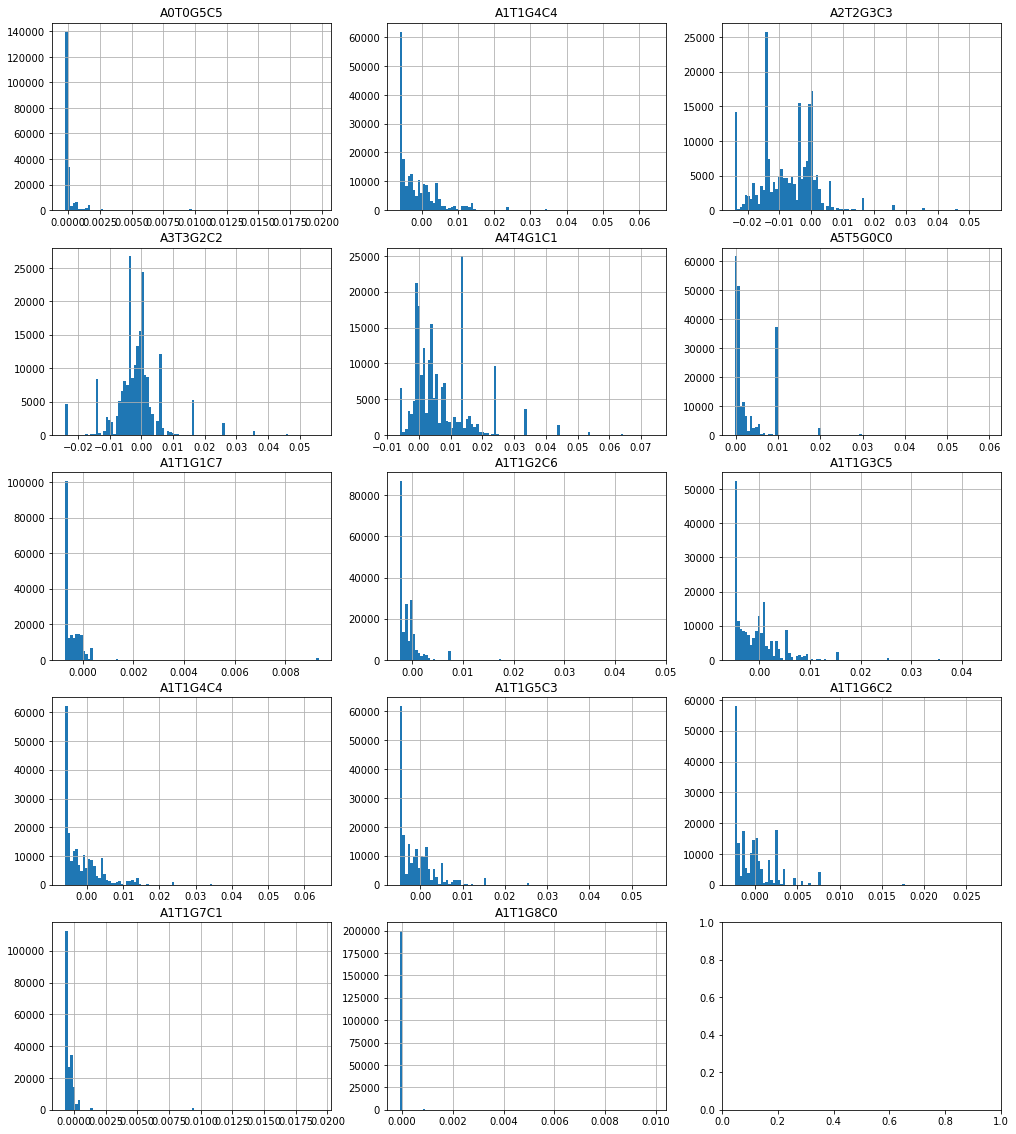

In [20]:
fig, axs = plt.subplots(5, 3, figsize=(17,20))
i = 0
for f in f:
    current_ax = axs.flat[i]
    current_ax.hist(train_d[f], bins=100)
    current_ax.set_title(f)
    current_ax.grid()
    i = i + 1

# Modeling

## ExtraTreeClassifier

LB = 0.98383

In [22]:
test.shape

(100000, 286)

In [23]:
N_SPLITS = 3 # 10 is better but memory allocated
N_ESTIMATORS = 100 # 300, 500 1000 is better but It will take a little longer.and memory problems.
RANDOM_STATE = 2022 # tried 1,42 

params = {
    'n_estimators' : N_ESTIMATORS,
    'n_jobs' : -1,
     'random_state' : RANDOM_STATE
}

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

scores_2 = []
scores_3 = []

y_probs_2 = []
y_probs_3 = []

folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  
    
    print("fold : ", fold + 1, end = ' ')
  
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]
    
    # model_2
    
    model_2 =  ExtraTreesClassifier(**params)
    model_2.fit(X_train, y_train)
    valid_pred_2 = model_2.predict(X_valid)
    valid_score_2 = accuracy_score(y_valid, valid_pred_2)
    print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
    scores_2.append(valid_score_2)
    y_pred_2 = model_2.predict(test)
    y_probs_2.append(model_2.predict_proba(test))
   
    
    # model_3
  
    model_3 = BaggingClassifier(model_2,  random_state = RANDOM_STATE)
    model_3.fit(X_train, y_train)
    valid_pred_3 = model_3.predict(X_valid)
    valid_score_3 = accuracy_score(y_valid, valid_pred_3)
    print( "model_3 :: Accuracy_score: ", valid_score_3)
    scores_3.append(valid_score_3)
    y_pred_3 = model_3.predict(test)
    y_probs_3.append(model_3.predict_proba(test))

fold :  1 madel_2 :: Accuracy_score:  0.9912700436497818 madel_3 :: Accuracy_score:  0.9934600326998365
fold :  2 madel_2 :: Accuracy_score:  0.9907450462747687 madel_3 :: Accuracy_score:  0.992680036599817
fold :  3 madel_2 :: Accuracy_score:  0.9911349113491135 madel_3 :: Accuracy_score:  0.992589925899259


In [24]:
# validations
print( "madel_2 :: Accuracy_score: ", scores_2)
print( "madel_3 :: Accuracy_score: ", scores_3)

madel_2 :: Accuracy_score:  [0.9912700436497818, 0.9907450462747687, 0.9911349113491135]
madel_3 :: Accuracy_score:  [0.9934600326998365, 0.992680036599817, 0.992589925899259]


In [27]:
# ETC+ bagging results
y_prob_3 = sum(y_probs_3) / len(y_probs_3)
y_pred_tuned_3 = label.inverse_transform(np.argmax(y_prob_3, axis = 1))
pd.Series(y_pred_tuned_3, index = test.index).value_counts().sort_index()  / len(test) * 100

Bacteroides_fragilis        10.037
Campylobacter_jejuni        10.245
Enterococcus_hirae           9.638
Escherichia_coli             8.366
Escherichia_fergusonii      11.058
Klebsiella_pneumoniae       10.239
Salmonella_enterica         10.237
Staphylococcus_aureus        9.971
Streptococcus_pneumoniae    10.086
Streptococcus_pyogenes      10.123
dtype: float64

In [28]:
y_prob_3 += np.array([0, 0, 0.01, 0.03, 0, 0, 0, 0.0, 0, 0]) # change may vary 
y_pred_tuned_3 = label.inverse_transform(np.argmax(y_prob_3, axis = 1))
pd.Series(y_pred_tuned_3, index=test.index).value_counts().sort_index() / len(test) * 100

Bacteroides_fragilis        10.000
Campylobacter_jejuni        10.224
Enterococcus_hirae           9.767
Escherichia_coli             9.823
Escherichia_fergusonii      10.019
Klebsiella_pneumoniae       10.118
Salmonella_enterica          9.984
Staphylococcus_aureus        9.925
Streptococcus_pneumoniae    10.052
Streptococcus_pyogenes      10.088
dtype: float64

## KNN

LB = 0.96762

In [44]:
# N_SPLITS = 5
# y_preds = []

# folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

# for fold, (train_id, test_id) in enumerate(folds.split(X, y)):
#     X_train = X.iloc[train_id]
#     y_train = y.iloc[train_id]
#     X_valid = X.iloc[test_id]
#     y_valid = y.iloc[test_id]

#     model = KNeighborsClassifier(3)
#     model.fit(X_train, y_train)

#     valid_score = model.score(X_valid, y_valid)

#     print(f'Fold: {fold + 1}')
#     print(f'Training Accuracy   :- {(model.score(X_train, y_train)*100).round(2)}%')
#     print(f'Validation Accuracy :- {(model.score(X_valid, y_valid)*100).round(2)}%')
#     y_preds.append(model.predict(X_test))

Fold: 1
Training Accuracy   :- 99.27%
Validation Accuracy :- 97.58%


NameError: name 'X_test' is not defined

In [50]:
model = KNeighborsClassifier(3)
model.fit(X, y)
y_preds_test = model.predict(test)
y_preds_test

KNeighborsClassifier(n_neighbors=3)

In [51]:
# model.score(X,y)

0.995665

# Submitting

In [32]:
# test = pd.read_csv("/home/mikhail/data/test.csv")
test.drop('row_id', inplace=True, axis =1)

In [33]:
sub.head(2)

row_id                    target
0  200000  Streptococcus_pneumoniae
1  200001  Streptococcus_pneumoniae

In [38]:
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["target"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
    return sub

In [39]:
save_submission(y_pred_tuned_3).head(3)

row_id                  target
0  200000  Escherichia_fergusonii
1  200001     Salmonella_enterica
2  200002      Enterococcus_hirae